In [1]:
pip install tldextract

Note: you may need to restart the kernel to use updated packages.


In [2]:
import requests
from bs4 import BeautifulSoup
import whois
import tldextract
import socket
from datetime import datetime
import pandas as pd

def extract_features(url):
    features = {}
    try:
        response = requests.get(url)
        soup = BeautifulSoup(response.text, 'html.parser')
    except:
        response = None
        soup = None

    #features['Domain'] = extract_domain(url)
    features['Have_IP'] = have_ip(url)
    features['Have_At'] = have_at(url)
    features['URL_Length'] = len(url)
    features['URL_Depth'] = url_depth(url)
    features['Redirection'] = redirection(response)
    features['https_Domain'] = https_domain(url)
    features['TinyURL'] = tiny_url(url)
    features['Prefix/Suffix'] = prefix_suffix(url)
    features['DNS_Record'] = dns_record(url)
    features['Web_Traffic'] = web_traffic(url)
    features['Domain_Age'] = domain_age(url)
    features['Domain_End'] = domain_end(url)
    features['iFrame'] = iframe(soup)
    features['Mouse_Over'] = mouse_over(response)
    features['Right_Click'] = right_click(response)
    features['Web_Forwards'] = web_forwards(response)
    features['Num_Dots'] = num_dots(url)
    features['HTTPS_Token'] = https_token(url)
    features['Suspicious_Words'] = suspicious_words(url)
    features['Content_Length'] = content_length(soup)
    features['Num_Images'] = num_images(soup)
    features['Num_Scripts'] = num_scripts(soup)

    features['Label'] = None

    return features



def have_ip(url):
    try:
        socket.inet_aton(url)
        return 1
    except socket.error:
        return 0

def have_at(url):
    return 1 if '@' in url else 0

def url_depth(url):
    return len(url.split('/')) - 3

def redirection(response):
    return 1 if response and len(response.history) > 0 else 0

def https_domain(url):
    return 1 if 'https' in url else 0

def tiny_url(url):
    return 1 if len(url) < 20 else 0

def prefix_suffix(url):
    return 1 if '-' in tldextract.extract(url).domain else 0

def dns_record(url):
    try:
        domain = tldextract.extract(url).fqdn
        socket.gethostbyname(domain)
        return 1
    except socket.gaierror:
        return 0

def web_traffic(url):
    return 0

def domain_age(url):
    try:
        domain = tldextract.extract(url).fqdn
        w = whois.whois(domain)
        creation_date = w.creation_date
        if isinstance(creation_date, list):
            creation_date = creation_date[0]
        age = (datetime.now() - creation_date).days
        return age
    except:
        return -1

def domain_end(url):
    try:
        domain = tldextract.extract(url).fqdn
        w = whois.whois(domain)
        expiration_date = w.expiration_date
        if isinstance(expiration_date, list):
            expiration_date = expiration_date[0]
        days_to_end = (expiration_date - datetime.now()).days
        return days_to_end
    except:
        return -1

def iframe(soup):
    return 1 if soup and soup.find('iframe') else 0

def mouse_over(response):
    return 1 if response and "onmouseover" in response.text else 0

def right_click(response):
    return 1 if response and "event.button == 2" in response.text else 0

def web_forwards(response):
    return 1 if response and len(response.history) > 1 else 0

def num_dots(url):
    return url.count('.')

def https_token(url):
    domain = tldextract.extract(url)
    return 1 if 'https' in domain.domain else 0

def suspicious_words(url):
    suspicious_keywords = ['free', 'login', 'secure', 'account', 'update']
    return 1 if any(keyword in url.lower() for keyword in suspicious_keywords) else 0

def content_length(soup):
    return len(soup.get_text()) if soup else 0

def num_images(soup):
    return len(soup.find_all('img')) if soup else 0

def num_scripts(soup):
    return len(soup.find_all('script')) if soup else 0

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib

df = pd.read_csv('./Dataset/url_features.csv')
df.head()

df.dropna(inplace=True)

X = df.drop(columns=['Label'])
y = df['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

joblib.dump(scaler, 'scaler.pkl')


svm = SVC()
svm.fit(X_train, y_train)
joblib.dump(svm, 'svm_model.pkl')

lr = LogisticRegression()
lr.fit(X_train, y_train)
joblib.dump(lr, 'lr_model.pkl')

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
joblib.dump(dt, 'dt_model.pkl')

rf = RandomForestClassifier()
rf.fit(X_train, y_train)
joblib.dump(rf, 'rf_model.pkl')

xgb = XGBClassifier()
xgb.fit(X_train, y_train)
joblib.dump(xgb, 'xgb_model.pkl')

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(classification_report(y_test, y_pred))

models = {
    "Support Vector Machine": joblib.load('svm_model.pkl'),
    "Logistic Regression": joblib.load('lr_model.pkl'),
    "Decision Tree": joblib.load('dt_model.pkl'),
    "Random Forest": joblib.load('rf_model.pkl'),
    "XGBoost": joblib.load('xgb_model.pkl')
}

for name, model in models.items():
    print(f"Evaluating {name}")
    evaluate_model(model, X_test, y_test)
    print("\n" + "="*50 + "\n")



Evaluating Support Vector Machine
Accuracy: 0.996
              precision    recall  f1-score   support

           0       1.00      0.99      1.00       988
           1       1.00      1.00      1.00      1012

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000



Evaluating Logistic Regression
Accuracy: 0.961
              precision    recall  f1-score   support

           0       0.97      0.95      0.96       988
           1       0.95      0.97      0.96      1012

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



Evaluating Decision Tree
Accuracy: 0.9985
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       988
           1       1.00      1.00      1.00      1012

    accuracy                           

In [6]:
#Check for Class Imbalance
print(df['Label'].value_counts())

Label
1    5000
0    5000
Name: count, dtype: int64


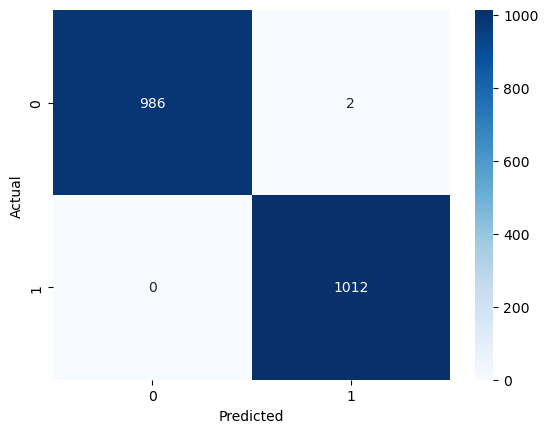

In [7]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = models["XGBoost"].predict(X_test)  # Replace with the model you want to check
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [8]:
#Cross-Validation
from sklearn.model_selection import cross_val_score

scores = cross_val_score(models["XGBoost"], X, y, cv=5)
print(f"Cross-validation scores: {scores}")
print(f"Average score: {scores.mean()}")


Cross-validation scores: [0.531  0.998  0.999  0.983  0.9655]
Average score: 0.8953


In [9]:
def predict_url(url, models, scaler):
    # Extract features from the URL
    features = extract_features(url)

    # Convert features to DataFrame
    features_df = pd.DataFrame([features])
    print(features_df)
    features_df = features_df.drop(columns=['Label'])
    # Scale the features using the loaded scaler
    scaled_features = scaler.transform(features_df)

    # Predict the label for the URL using each model
    predictions = {}
    for name, model in models.items():
        prediction = model.predict(scaled_features)
        predictions[name] = 'phishing' if prediction[0] == 1 else 'benign'

    return predictions

# Example URL
url = "https://www.kaggle.com/datasets/eswarchandt/phishing-website-detector/suggestions?status=pending&yourSuggestions=true"  # Replace with the actual URL
predictions = predict_url(url, models, scaler)

# Print the predictions
for model_name, prediction in predictions.items():
    print(f"{model_name}: {prediction}")


   Have_IP  Have_At  URL_Length  URL_Depth  Redirection  https_Domain  \
0        0        0         117          4            0             1   

   TinyURL  Prefix/Suffix  DNS_Record  Web_Traffic  ...  Mouse_Over  \
0        0              0           1            0  ...           0   

   Right_Click  Web_Forwards  Num_Dots  HTTPS_Token  Suspicious_Words  \
0            0             0         2            0                 0   

   Content_Length  Num_Images  Num_Scripts  Label  
0              90           0           16   None  

[1 rows x 23 columns]
Support Vector Machine: phishing
Logistic Regression: phishing
Decision Tree: phishing
Random Forest: phishing
XGBoost: phishing
